In [107]:
import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
import plotly.graph_objects as go

import os
import sys
sys.path.append('../utils')
sys.path.append('..')

from utils import read_all_datasets, prepare_data
import fcn
import fcn_org

In [ ]:
dataset_names = ['ArrowHead', 'BeetleFly', 'Ham', 'MoteStrain', 'OliveOil', 'Wine', 'Lightning7', 'InlineSkate', 'Beef', 'ACSF1', 'Yoga', 'GunPointOldVersusYoung',
                 'FreezerSmallTrain', 'WordSynonyms', 'Car', 'ProximalPhalanxTW', 'InsectWingbeatSound','FaceAll', 'EOGVerticalSignal',  'Earthquakes']

datasets_dict = read_all_datasets(dataset_names)
base_model_perf = []
column_names = ['Dataset', 'base_1', 'base_2', 'ensemble_0.1', 'ensemble_0.2', 'ensemble_0.3', 'ensemble_0.4', 'ens_base', 'ensemble_0.6', 'ensemble_0.7', 'ensemble_0.8', 'ensemble_0.9',]
res_df_base = pd.DataFrame(columns=column_names)

for dataset_name in dataset_names:
    print('dataset_name: ', dataset_name)
    trainloader, valloader, input_shape, nb_classes = prepare_data(datasets_dict, dataset_name)
    row = [dataset_name]
    # --------------------------------------------------------------------------------------------------------------------------------------------------------
    filter_count = 128
    base_model_1 = fcn.Classifier_FCN(input_shape, nb_classes, filter_count)
    base_model_1.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_base/fcn_test_removeable_fcn_3_layer_base_seed_4580/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    base_model_1.eval()
    
    co_model_1 = fcn.Classifier_FCN(input_shape, nb_classes,filter_count)
    co_model_1.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_base/fcn_test_removeable_fcn_3_layer_ref_seed_6528/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    co_model_1.eval()


    predictions_1, predictions_2,  ground_truth_labels = [], [], []

    with torch.no_grad():
        for inputs, targets in valloader:  # Replace with your test data loader
            outputs_1 = base_model_1(inputs.float())
            predictions_1.extend(outputs_1)

            outputs_2 = co_model_1(inputs.float())
            predictions_2.extend(outputs_2)

            ground_truth_labels.extend(targets)

    predictions_1 = torch.stack(predictions_1)
    predictions_2 = torch.stack(predictions_2)

    for iter_num in range(1, 2):
        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_base/fcn_test_removeable_fcn_3_layer_base_seed_4580/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])
    
        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_base/fcn_test_removeable_fcn_3_layer_ref_seed_6528/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])


    for lambda_ in np.arange(0.1, 1, 0.1):
        # print('alpha: ', lambda_)
        ensemble_predictions = ((1-lambda_) * predictions_1 + lambda_ * predictions_2) / 2
        _, predicted = torch.max(ensemble_predictions.data, 1)
        ensemble_accuracy = accuracy_score(ground_truth_labels, predicted)
        # print('base 2 ensemble accuracy: ', ensemble_accuracy)
        row.append(ensemble_accuracy)
        # print('row: ', row)

    res_df_base = res_df_base.append(pd.Series(row, index=column_names), ignore_index=True)

    print('\n')

In [3]:
res_df_base

,Dataset,base_1,base_2,ensemble_0.1,ensemble_0.2,ensemble_0.3,ensemble_0.4,ens_base,ensemble_0.6,ensemble_0.7,ensemble_0.8,ensemble_0.9
0,ArrowHead,77.714286,81.714286,0.788571,0.782857,0.800000,0.800000,0.800000,0.811429,0.822857,0.828571,0.822857
1,BeetleFly,50.000000,60.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.550000,0.600000
2,Ham,42.857143,42.857143,0.428571,0.419048,0.409524,0.409524,0.409524,0.409524,0.409524,0.409524,0.428571
3,MoteStrain,90.095847,91.373802,0.904153,0.906550,0.908147,0.908946,0.908946,0.913738,0.915335,0.912939,0.914537
4,OliveOil,43.333333,13.333333,0.400000,0.333333,0.266667,0.200000,0.166667,0.200000,0.200000,0.166667,0.133333
5,Wine,50.000000,50.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
6,Lightning7,67.123288,73.972603,0.684932,0.684932,0.684932,0.684932,0.712329,0.726027,0.712329,0.712329,0.739726
7,InlineSkate,34.727273,41.090909,0.352727,0.360000,0.365455,0.370909,0.370909,0.376364,0.387273,0.400000,0.403636
8,Beef,60.000000,60.000000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000
9,ACSF1,38.000000,47.000000,0.390000,0.430000,0.500000,0.480000,0.500000,0.490000,0.490000,0.490000,0.470000


In [ ]:
dataset_names = ['ArrowHead', 'BeetleFly', 'Ham', 'MoteStrain', 'OliveOil', 'Wine', 'Lightning7', 'InlineSkate', 'Beef', 'ACSF1', 'Yoga', 'GunPointOldVersusYoung',
                 'FreezerSmallTrain', 'WordSynonyms', 'Car', 'ProximalPhalanxTW', 'InsectWingbeatSound','FaceAll', 'EOGVerticalSignal',  'Earthquakes']


datasets_dict = read_all_datasets(dataset_names)
base_model_perf = []
column_names = ['Dataset', 'base_1', 'co_1', 'ensemble_0.1', 'ensemble_0.2', 'ensemble_0.3', 'ensemble_0.4', 'ens_co', 'ensemble_0.6', 'ensemble_0.7', 'ensemble_0.8', 'ensemble_0.9',]
res_df_co = pd.DataFrame(columns=column_names)

for dataset_name in dataset_names:
    print('dataset_name: ', dataset_name)
    trainloader, valloader, input_shape, nb_classes = prepare_data(datasets_dict, dataset_name)
    row = [dataset_name]
    # --------------------------------------------------------------------------------------------------------------------------------------------------------
    filter_count = 128
    base_model_1 = fcn.Classifier_FCN(input_shape, nb_classes, filter_count)
    base_model_1.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_base/fcn_test_removeable_fcn_3_layer_ref_seed_6528/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    base_model_1.eval()
    
    
    co_model_1 = fcn.Classifier_FCN(input_shape, nb_classes,filter_count)
    co_model_1.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_cotrained/fcn_orig_co_fcn_3_layer_test_remove_base_seed_4580_ref_seed_6528/filter_' + str(filter_count) + '/' + dataset_name  + '/iter_1/last_model.pt', map_location=torch.device('cpu')))
    co_model_1.eval()


    predictions_1, predictions_2,  ground_truth_labels = [], [], []

    with torch.no_grad():
        for inputs, targets in valloader:  # Replace with your test data loader
            outputs_1 = base_model_1(inputs.float())
            predictions_1.extend(outputs_1)

            outputs_2 = co_model_1(inputs.float())
            predictions_2.extend(outputs_2)

            ground_truth_labels.extend(targets)

    predictions_1 = torch.stack(predictions_1)
    predictions_2 = torch.stack(predictions_2)

    for iter_num in range(1, 2):
        
        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_base/fcn_test_removeable_fcn_3_layer_ref_seed_6528/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])
    
        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_cotrained/fcn_orig_co_fcn_3_layer_test_remove_base_seed_4580_ref_seed_6528/filter_128/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])


    for lambda_ in np.arange(0.1, 1, 0.1):
        # print('alpha: ', lambda_)
        ensemble_predictions = ((1-lambda_) * predictions_1 + lambda_ * predictions_2) / 2
        _, predicted = torch.max(ensemble_predictions.data, 1)
        ensemble_accuracy = accuracy_score(ground_truth_labels, predicted)
        # print('base 2 ensemble accuracy: ', ensemble_accuracy)
        row.append(ensemble_accuracy)
        # print('row: ', row)

    res_df_co = res_df_co.append(pd.Series(row, index=column_names), ignore_index=True)

    print('\n')

In [52]:
res_df_co

,Dataset,base_1,co_1,ensemble_0.1,ensemble_0.2,ensemble_0.3,ensemble_0.4,ens_co,ensemble_0.6,ensemble_0.7,ensemble_0.8,ensemble_0.9
0,ArrowHead,81.714286,79.428571,0.817143,0.822857,0.817143,0.811429,0.817143,0.822857,0.805714,0.800000,0.800000
1,BeetleFly,60.000000,60.000000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000
2,Ham,42.857143,43.809524,0.419048,0.419048,0.438095,0.457143,0.466667,0.476190,0.485714,0.504762,0.504762
3,MoteStrain,91.373802,91.214058,0.919329,0.921725,0.919329,0.916933,0.914537,0.914537,0.916933,0.913738,0.911342
4,OliveOil,13.333333,13.333333,0.166667,0.233333,0.266667,0.366667,0.333333,0.300000,0.300000,0.300000,0.300000
5,Wine,50.000000,38.888889,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
6,Lightning7,73.972603,73.972603,0.739726,0.726027,0.726027,0.739726,0.739726,0.739726,0.753425,0.753425,0.753425
7,InlineSkate,41.090909,40.000000,0.405455,0.398182,0.394545,0.390909,0.390909,0.380000,0.350909,0.325455,0.312727
8,Beef,60.000000,56.666667,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.566667,0.566667
9,ACSF1,47.000000,51.000000,0.470000,0.470000,0.470000,0.470000,0.470000,0.490000,0.490000,0.500000,0.510000


In [5]:
res_df_co

,Dataset,base_1,co_1,ensemble_0.1,ensemble_0.2,ensemble_0.3,ensemble_0.4,ens_co,ensemble_0.6,ensemble_0.7,ensemble_0.8,ensemble_0.9
0,ArrowHead,81.714286,79.428571,0.817143,0.822857,0.817143,0.811429,0.817143,0.822857,0.805714,0.800000,0.800000
1,BeetleFly,60.000000,60.000000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000
2,Ham,42.857143,43.809524,0.419048,0.419048,0.438095,0.457143,0.466667,0.476190,0.485714,0.504762,0.504762
3,MoteStrain,91.373802,91.214058,0.919329,0.921725,0.919329,0.916933,0.914537,0.914537,0.916933,0.913738,0.911342
4,OliveOil,13.333333,13.333333,0.166667,0.233333,0.266667,0.366667,0.333333,0.300000,0.300000,0.300000,0.300000
5,Wine,50.000000,38.888889,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
6,Lightning7,73.972603,73.972603,0.739726,0.726027,0.726027,0.739726,0.739726,0.739726,0.753425,0.753425,0.753425
7,InlineSkate,41.090909,40.000000,0.405455,0.398182,0.394545,0.390909,0.390909,0.380000,0.350909,0.325455,0.312727
8,Beef,60.000000,56.666667,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.566667,0.566667
9,ACSF1,47.000000,51.000000,0.470000,0.470000,0.470000,0.470000,0.470000,0.490000,0.490000,0.500000,0.510000


In [6]:
res_df_base

,Dataset,base_1,base_2,ensemble_0.1,ensemble_0.2,ensemble_0.3,ensemble_0.4,ens_base,ensemble_0.6,ensemble_0.7,ensemble_0.8,ensemble_0.9
0,ArrowHead,77.714286,81.714286,0.788571,0.782857,0.800000,0.800000,0.800000,0.811429,0.822857,0.828571,0.822857
1,BeetleFly,50.000000,60.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.550000,0.600000
2,Ham,42.857143,42.857143,0.428571,0.419048,0.409524,0.409524,0.409524,0.409524,0.409524,0.409524,0.428571
3,MoteStrain,90.095847,91.373802,0.904153,0.906550,0.908147,0.908946,0.908946,0.913738,0.915335,0.912939,0.914537
4,OliveOil,43.333333,13.333333,0.400000,0.333333,0.266667,0.200000,0.166667,0.200000,0.200000,0.166667,0.133333
5,Wine,50.000000,50.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
6,Lightning7,67.123288,73.972603,0.684932,0.684932,0.684932,0.684932,0.712329,0.726027,0.712329,0.712329,0.739726
7,InlineSkate,34.727273,41.090909,0.352727,0.360000,0.365455,0.370909,0.370909,0.376364,0.387273,0.400000,0.403636
8,Beef,60.000000,60.000000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000
9,ACSF1,38.000000,47.000000,0.390000,0.430000,0.500000,0.480000,0.500000,0.490000,0.490000,0.490000,0.470000


In [ ]:
dataset_names = ['ArrowHead', 'BeetleFly', 'Ham', 'MoteStrain', 'OliveOil', 'Wine', 'Lightning7', 'InlineSkate', 'Beef', 'ACSF1', 'Yoga',  
'GunPointOldVersusYoung', 'FreezerSmallTrain', 'WordSynonyms', 'Car', 'ProximalPhalanxTW', 'InsectWingbeatSound', 'FaceAll', 'EOGVerticalSignal',  'Earthquakes']
datasets_dict = read_all_datasets(dataset_names)
base_model_perf = []
column_names = ['Dataset', 'ref_1', 'base_2', 'co_1', 'ens_base', 'ens_co',]
res_df = pd.DataFrame(columns=column_names)

for dataset_name in dataset_names:
    print('dataset_name: ', dataset_name)
    trainloader, valloader, input_shape, nb_classes = prepare_data(datasets_dict, dataset_name)
    row = [dataset_name]
    # --------------------------------------------------------------------------------------------------------------------------------------------------------
    filter_count = 128
    base_model_1 = fcn.Classifier_FCN(input_shape, nb_classes, filter_count)
    base_model_1.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_base/fcn_test_removeable_fcn_3_layer_ref_seed_6528/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    base_model_1.eval()

    base_model_2 = fcn.Classifier_FCN(input_shape, nb_classes, filter_count)
    base_model_2.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_base/fcn_test_removeable_fcn_3_layer_base_seed_4580/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    base_model_2.eval()

    co_model_1 = fcn.Classifier_FCN(input_shape, nb_classes,filter_count)
    co_model_1.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_cotrained/fcn_orig_co_fcn_3_layer_test_remove_normalize_lambda_sigmoid_base_seed_4580_ref_seed_6528/filter_' + str(filter_count) + '/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    co_model_1.eval()


    predictions_1, predictions_2, predictions_3, ground_truth_labels = [], [], [], []

    with torch.no_grad():
        for inputs, targets in valloader:  # Replace with your test data loader
            outputs_1 = base_model_1(inputs.float())
            predictions_1.extend(outputs_1)

            outputs_2 = base_model_2(inputs.float())
            predictions_2.extend(outputs_2)

            outputs_3 = co_model_1(inputs.float())
            predictions_3.extend(outputs_3)

            ground_truth_labels.extend(targets)

    predictions_1 = torch.stack(predictions_1)
    predictions_2 = torch.stack(predictions_2)
    predictions_3 = torch.stack(predictions_3)


    for iter_num in range(1, 2):
        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_base/fcn_test_removeable_fcn_3_layer_ref_seed_6528/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])
    
        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_base/fcn_test_removeable_fcn_3_layer_base_seed_4580/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])

        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_cotrained/fcn_orig_co_fcn_3_layer_test_remove_normalize_lambda_sigmoid_base_seed_4580_ref_seed_6528/filter_128/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])



    ensemble_predictions_base = predictions_1 + predictions_2
    _, predicted_base = torch.max(ensemble_predictions_base.data, 1)
    ensemble_accuracy_base = accuracy_score(ground_truth_labels, predicted_base)
    row.append(ensemble_accuracy_base)

    ensemble_predictions_co = predictions_1 + predictions_3
    _, predicted_co = torch.max(ensemble_predictions_co.data, 1)
    ensemble_accuracy_co = accuracy_score(ground_truth_labels, predicted_co)
    row.append(ensemble_accuracy_co)
    # print('row: ', row)

    res_df = res_df.append(pd.Series(row, index=column_names), ignore_index=True)

    print('\n')

In [57]:
res_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
0,ArrowHead,81.714286,77.714286,75.428571,0.800000,0.794286
1,BeetleFly,60.000000,50.000000,50.000000,0.500000,0.500000
2,Ham,42.857143,42.857143,44.761905,0.409524,0.438095
3,MoteStrain,91.373802,90.095847,90.495208,0.908946,0.912939
4,OliveOil,13.333333,43.333333,40.000000,0.166667,0.433333
5,Wine,50.000000,50.000000,38.888889,0.500000,0.500000
6,Lightning7,73.972603,67.123288,69.863014,0.712329,0.726027
7,InlineSkate,41.090909,34.727273,39.272727,0.370909,0.401818
8,Beef,60.000000,60.000000,60.000000,0.600000,0.600000
9,ACSF1,47.000000,38.000000,41.000000,0.500000,0.490000


In [54]:
res_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
0,ArrowHead,81.714286,77.714286,75.428571,0.800000,0.788571
1,BeetleFly,60.000000,50.000000,50.000000,0.500000,0.500000
2,Ham,42.857143,42.857143,44.761905,0.409524,0.419048
3,MoteStrain,91.373802,90.095847,90.495208,0.908946,0.912939
4,OliveOil,13.333333,43.333333,40.000000,0.166667,0.266667
5,Wine,50.000000,50.000000,38.888889,0.500000,0.500000
6,Lightning7,73.972603,67.123288,69.863014,0.712329,0.739726
7,InlineSkate,41.090909,34.727273,39.272727,0.370909,0.405455
8,Beef,60.000000,60.000000,60.000000,0.600000,0.600000
9,ACSF1,47.000000,38.000000,41.000000,0.500000,0.480000


In [44]:
res_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
0,ArrowHead,81.714286,77.714286,82.285714,0.800000,0.828571
1,BeetleFly,60.000000,50.000000,60.000000,0.500000,0.600000
2,Ham,42.857143,42.857143,44.761905,0.409524,0.428571
3,MoteStrain,91.373802,90.095847,92.092652,0.908946,0.924920
4,OliveOil,13.333333,43.333333,50.000000,0.166667,0.266667
5,Wine,50.000000,50.000000,50.000000,0.500000,0.500000
6,Lightning7,73.972603,67.123288,68.493151,0.712329,0.726027
7,InlineSkate,41.090909,34.727273,40.000000,0.370909,0.407273
8,Beef,60.000000,60.000000,53.333333,0.600000,0.600000
9,ACSF1,47.000000,38.000000,47.000000,0.500000,0.500000


In [41]:
res_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
0,ArrowHead,81.714286,77.714286,82.285714,0.800000,0.828571
1,BeetleFly,60.000000,50.000000,60.000000,0.500000,0.800000
2,Ham,42.857143,42.857143,44.761905,0.409524,0.428571
3,MoteStrain,91.373802,90.095847,92.092652,0.908946,0.930511
4,OliveOil,13.333333,43.333333,50.000000,0.166667,0.266667
5,Wine,50.000000,50.000000,50.000000,0.500000,0.500000
6,Lightning7,73.972603,67.123288,68.493151,0.712329,0.780822
7,InlineSkate,41.090909,34.727273,40.000000,0.370909,0.381818
8,Beef,60.000000,60.000000,53.333333,0.600000,0.600000
9,ACSF1,47.000000,38.000000,47.000000,0.500000,0.510000


In [12]:
res_df[res_df['ens_co'] < res_df['ens_base']]

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
9,ACSF1,47.000000,38.000000,51.000000,0.500000,0.470000
10,Yoga,85.100000,88.833333,89.800000,0.893667,0.886333
14,Car,88.333333,91.666667,88.333333,0.900000,0.883333
16,InsectWingbeatSound,38.434343,37.727273,36.464646,0.387879,0.387374
17,FaceAll,20.059172,12.721893,9.467456,0.171006,0.149112
18,EOGVerticalSignal,18.508287,23.204420,21.270718,0.226519,0.212707


In [32]:
res_df[res_df['ens_co'] < res_df['ens_base']]

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
10,Yoga,85.100000,88.833333,81.333333,0.893667,0.837000
14,Car,88.333333,91.666667,86.666667,0.900000,0.883333
15,ProximalPhalanxTW,81.951220,80.487805,80.000000,0.824390,0.814634
17,FaceAll,20.059172,12.721893,9.940828,0.171006,0.126627
18,EOGVerticalSignal,18.508287,23.204420,19.889503,0.226519,0.207182


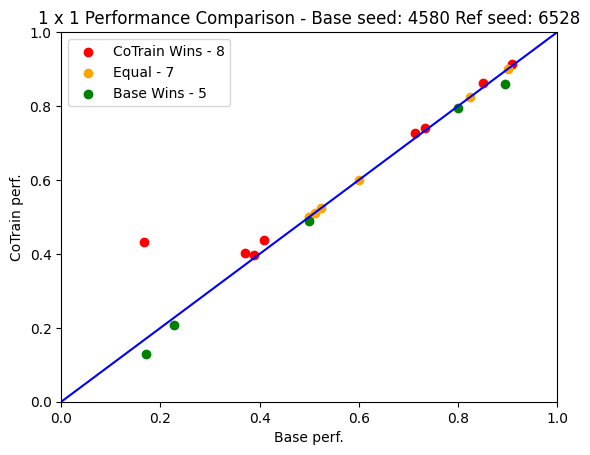

In [58]:
import matplotlib.pyplot as plt
base_seed = 4580
ref_seed = 6528

# Define the points for the diagonal line
x_line = [0, 1]
y_line = [0, 1]

# Define points for scatter plot
x_scatter = res_df['ens_base'].tolist() 
y_scatter = res_df['ens_co'].tolist() 

x_above = np.array([x for x, y in zip(x_scatter, y_scatter) if y > x])
y_above = np.array([y for x, y in zip(x_scatter, y_scatter) if y > x])

x_same = np.array([x for x, y in zip(x_scatter, y_scatter) if y == x])
y_same = np.array([y for x, y in zip(x_scatter, y_scatter) if y == x])

x_below = np.array([x for x, y in zip(x_scatter, y_scatter) if y < x])
y_below = np.array([y for x, y in zip(x_scatter, y_scatter) if y < x])

# Plot the diagonal line
plt.plot(x_line, y_line,  color='blue')
num_wins = res_df[res_df['ens_co'] > res_df['ens_base']].shape[0]
num_ties = res_df[res_df['ens_co'] == res_df['ens_base']].shape[0]
num_losses = res_df[res_df['ens_co'] < res_df['ens_base']].shape[0]

# Plot the scatter points
plt.scatter(x_above, y_above, label='CoTrain Wins - ' + str(num_wins), color='red')
plt.scatter(x_same, y_same, label='Equal - ' + str(num_ties), color='orange')
plt.scatter(x_below, y_below, label='Base Wins - ' + str(num_losses), color='green')

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Base perf.')
plt.ylabel('CoTrain perf.')
plt.title('1 x 1 Performance Comparison - Base seed: '+ str(base_seed) + ' Ref seed: '+ str(ref_seed))

# Add a legend
plt.legend()
plt.savefig('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/fcn_kl_co' + str(base_seed) + '_ref_seed_' + str(ref_seed) + '_run_2.png')
# Display the plot
plt.show()

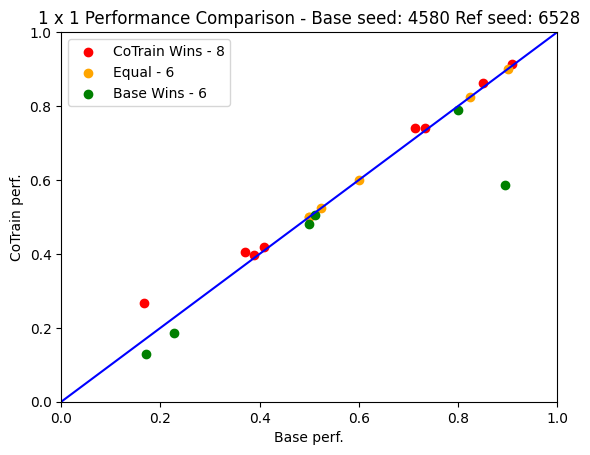

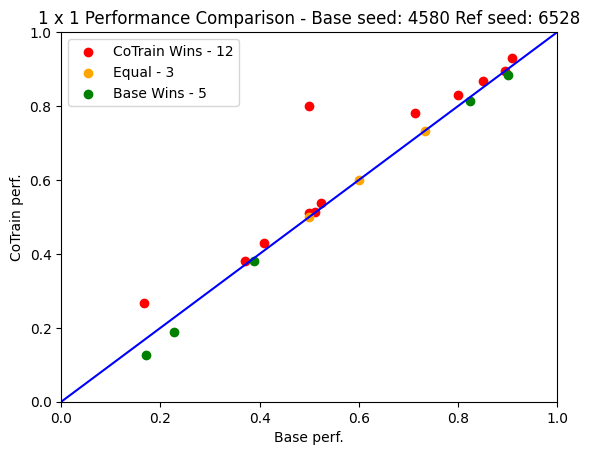

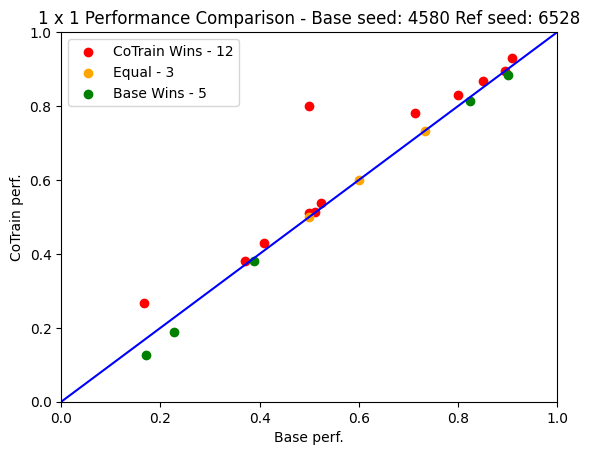

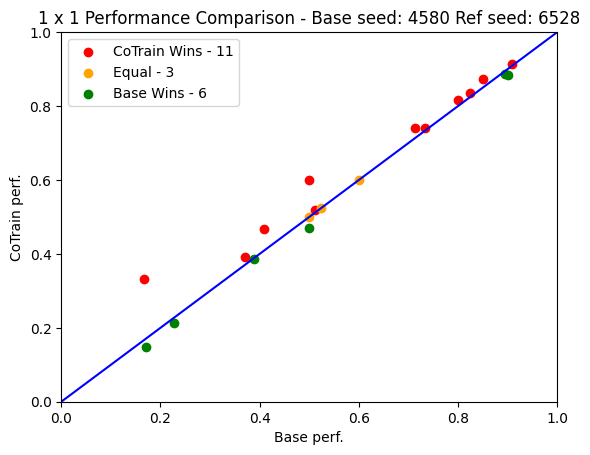

In [ ]:
dataset_names = ['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ',
                                 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown',
                                 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX',
                                 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction',
                                 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW',
                                 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200',
                                 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal',
                                 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR',
                                 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain',
                                 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2',
                                 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint',
                                 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung',
                                 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate',
                                 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'InsectWingbeatSound',
                                 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7',
                                 'Mallat', 'Meat', 'MedicalImages', 'MelbournePedestrian',
                                 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect',
                                 'MiddlePhalanxTW', 'MixedShapesRegularTrain', 'MixedShapesSmallTrain',
                                 'MoteStrain', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2',
                                 'OliveOil', 'OSULeaf', 'PhalangesOutlinesCorrect', 'Phoneme',
                                 'PickupGestureWiimoteZ', 'PigAirwayPressure', 'PigArtPressure', 'PigCVP',
                                 'PLAID', 'Plane', 'PowerCons', 'ProximalPhalanxOutlineAgeGroup',
                                 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW', 'RefrigerationDevices',
                                 'Rock', 'ScreenType', 'SemgHandGenderCh2', 'SemgHandMovementCh2',
                                 'SemgHandSubjectCh2', 'ShakeGestureWiimoteZ', 'ShapeletSim', 'ShapesAll',
                                 'SmallKitchenAppliances', 'SmoothSubspace', 'SonyAIBORobotSurface1',
                                 'SonyAIBORobotSurface2', 'StarLightCurves', 'Strawberry', 'SwedishLeaf',
                                 'Symbols', 'SyntheticControl', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace',
                                 'TwoLeadECG', 'TwoPatterns', 'UMD', 'UWaveGestureLibraryAll',
                                 'UWaveGestureLibraryX', 'UWaveGestureLibraryY', 'UWaveGestureLibraryZ',
                                 'Wafer', 'Wine', 'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga']


datasets_dict = read_all_datasets(dataset_names)
base_model_perf = []
column_names = ['Dataset', 'ref_1', 'base_2', 'co_1', 'ens_base', 'ens_co',]
res_df = pd.DataFrame(columns=column_names)

for dataset_name in dataset_names:
    print('dataset_name: ', dataset_name)
    trainloader, valloader, input_shape, nb_classes = prepare_data(datasets_dict, dataset_name)
    row = [dataset_name]
    # --------------------------------------------------------------------------------------------------------------------------------------------------------
    filter_count = 128
    base_model_1 = fcn.Classifier_FCN(input_shape, nb_classes, filter_count)
    base_model_1.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_base/fcn_orig_128_datasets_ref_seed_6528/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    base_model_1.eval()

    base_model_2 = fcn.Classifier_FCN(input_shape, nb_classes, filter_count)
    base_model_2.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_base/fcn_orig_128_datasets_base_seed_4580/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    base_model_2.eval()

    co_model_1 = fcn.Classifier_FCN(input_shape, nb_classes,filter_count)
    co_model_1.load_state_dict(torch.load('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/FCN_cotrained/fcn_orig_128_datasets_run_2_base_seed_4580_ref_seed_6528/filter_' + str(filter_count) + '/' + dataset_name  + '/iter_1/best_model.pt', map_location=torch.device('cpu')))
    co_model_1.eval()


    predictions_1, predictions_2, predictions_3, ground_truth_labels = [], [], [], []

    with torch.no_grad():
        for inputs, targets in valloader:  # Replace with your test data loader
            outputs_1 = base_model_1(inputs.float())
            predictions_1.extend(outputs_1)

            outputs_2 = base_model_2(inputs.float())
            predictions_2.extend(outputs_2)

            outputs_3 = co_model_1(inputs.float())
            predictions_3.extend(outputs_3)

            ground_truth_labels.extend(targets)

    predictions_1 = torch.stack(predictions_1)
    predictions_2 = torch.stack(predictions_2)
    predictions_3 = torch.stack(predictions_3)


    for iter_num in range(1, 2):
        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_base/fcn_orig_128_datasets_ref_seed_6528/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])
    
        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_base/fcn_orig_128_datasets_base_seed_4580/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])

        df = pd.read_csv('/home/javidan/Codes/Results/results/Diverse_Filters/' + 'FCN/FCN_cotrained/fcn_orig_128_datasets_run_2_base_seed_4580_ref_seed_6528/filter_128/' + dataset_name  + '/iter_' + str(iter_num) + '/df_metrics.csv')
        print(df['Accuracy'][0])
        row.append(df['Accuracy'][0])



    ensemble_predictions_base = predictions_1 + predictions_2
    _, predicted_base = torch.max(ensemble_predictions_base.data, 1)
    ensemble_accuracy_base = accuracy_score(ground_truth_labels, predicted_base)
    row.append(ensemble_accuracy_base)

    ensemble_predictions_co = predictions_1 + predictions_3
    _, predicted_co = torch.max(ensemble_predictions_co.data, 1)
    ensemble_accuracy_co = accuracy_score(ground_truth_labels, predicted_co)
    row.append(ensemble_accuracy_co)
    # print('row: ', row)

    res_df = res_df.append(pd.Series(row, index=column_names), ignore_index=True)

    print('\n')

In [11]:
summ_df = pd.read_csv('/home/javidan/Task_24/DataSummary.csv')
summ_df.rename(columns={'Name': 'Dataset', }, inplace=True)
summ_df.head()

,ID,Type,Dataset,Train,Test,Class,Length,ED (w=0),DTW (learned_w),DTW (w=100),Default rate,Data donor/editor
0,1,Image,Adiac,390,391,37,176,0.3887,0.3913 (3),0.3964,0.9591,A. Jalba
1,2,Image,ArrowHead,36,175,3,251,0.2000,0.2000 (0),0.2971,0.6057,L. Ye & E. Keogh
2,3,Spectro,Beef,30,30,5,470,0.3333,0.3333 (0),0.3667,0.8000,K. Kemsley & A. Bagnall
3,4,Image,BeetleFly,20,20,2,512,0.2500,0.3000 (7),0.3000,0.5000,J. Hills & A. Bagnall
4,5,Image,BirdChicken,20,20,2,512,0.4500,0.3000 (6),0.2500,0.5000,J. Hills & A. Bagnall


In [133]:
main_df['Type'].value_counts()

Image           32
Sensor          30
Motion          17
Device           9
Spectro          8
Simulated        8
ECG              6
Spectrum         4
Trajectory       3
Hemodynamics     3
Traffic          2
EOG              2
EPG              2
HRM              1
Power            1
Name: Type, dtype: int64

In [158]:
tmp_df = main_df[main_df['Type'] == 'Image']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(14, 17)

In [159]:
tmp_df = main_df[main_df['Type'] == 'Sensor']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(13, 17)

In [143]:
tmp_df = main_df[main_df['Type'] == 'Motion']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(8, 17)

In [144]:
tmp_df = main_df[main_df['Type'] == 'Device']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(1, 17)

In [145]:
tmp_df = main_df[main_df['Type'] == 'Spectro']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(2, 17)

In [146]:
tmp_df = main_df[main_df['Type'] == 'Simulated']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(6, 17)

In [147]:
tmp_df = main_df[main_df['Type'] == 'ECG']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(3, 17)

In [148]:
tmp_df = main_df[main_df['Type'] == 'Spectrum']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(1, 17)

In [149]:
tmp_df = main_df[main_df['Type'] == 'Trajectory']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(2, 17)

In [150]:
tmp_df = main_df[main_df['Type'] == 'Hemodynamics']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(0, 17)

In [151]:
tmp_df = main_df[main_df['Type'] == 'Traffic']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(1, 17)

In [152]:
tmp_df = main_df[main_df['Type'] == 'EOG']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(0, 17)

In [153]:
tmp_df = main_df[main_df['Type'] == 'EPG']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(2, 17)

In [154]:
tmp_df = main_df[main_df['Type'] == 'HRM']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(1, 17)

In [155]:
tmp_df = main_df[main_df['Type'] == 'Power']
tmp_df[tmp_df['ens_co'] > tmp_df['ens_base']].shape

(0, 17)

In [13]:
main_df = pd.merge(res_df, summ_df, on='Dataset')

In [18]:
main_df[main_df['ens_co'] > main_df['ens_base']]['Train '].mean()

351.64814814814815

In [19]:
main_df[main_df['ens_co'] < main_df['ens_base']]['Train '].mean()

719.7169811320755

In [20]:
main_df[main_df['ens_co'] > main_df['ens_base']]['Train '].median()

208.0

In [23]:
main_df[main_df['ens_co'] < main_df['ens_base']]['Train '].median()

250.0

In [125]:
main_df[(main_df['ens_co'] > main_df['ens_base']) & (main_df['Length'] != 'Vary')]['Length'].astype(int).mean()

480.8541666666667

In [122]:
main_df[(main_df['ens_co'] > main_df['ens_base']) & (main_df['Length'] != 'Vary')]['Length'].astype(int).median()

288.0

In [124]:
main_df[(main_df['ens_co'] < main_df['ens_base']) & (main_df['Length'] != 'Vary')]['Length'].astype(int).mean()

538.38

In [123]:
main_df[(main_df['ens_co'] < main_df['ens_base']) & (main_df['Length'] != 'Vary')]['Length'].astype(int).median()

301.0

In [96]:
3.0420338573169336e+138

3.0420338573169336e+138

In [36]:
main_df[(main_df['ens_co'] > main_df['ens_base']) & (main_df['Length'] != 'Vary')]['Length']

0      1460
1       176
5       251
7       512
9       128
12       24
13      166
22       80
25      288
27      288
28      512
31      136
35     1751
36      131
39      270
45      201
52      150
56     2709
57     1092
61      601
62      601
63      256
64       24
67      319
68     1024
69      448
74       80
78      750
79      750
91       80
92       80
95     2844
101     500
102     512
104      15
105      70
109     128
110     398
111      60
112     277
113     343
116     128
118     945
119     315
120     315
121     315
122     152
127     426
Name: Length, dtype: object

In [35]:
main_df[(main_df['ens_co'] < main_df['ens_base']) & (main_df['Length'] != 'Vary')]['Length'][:]

11      128
14     1639
16      720
17      300
18      300
19      300
20       46
23       80
24       80
26      288
29       96
30      140
32       96
33     1250
34     1250
37      350
38      131
40      463
41      500
42      500
43      301
44      301
53      150
55      431
58      512
60     1882
70       99
71       24
72       80
73       80
76     1024
77       84
80      570
81      427
82       80
83     1024
86     2000
87     2000
90      144
93       80
94      720
96      720
98     1500
103     720
106      65
107    1024
117     150
124     270
125     900
126     900
Name: Length, dtype: object

In [8]:
res_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
0,ACSF1,47.000000,40.000000,41.000000,0.430000,0.460000
1,Adiac,59.846547,74.168798,77.237852,0.734015,0.736573
2,AllGestureWiimoteX,20.285714,23.142857,17.142857,0.218571,0.187143
3,AllGestureWiimoteY,27.285714,22.285714,23.285714,0.242857,0.250000
4,AllGestureWiimoteZ,27.857143,23.714286,23.714286,0.265714,0.280000
...,...,...,...,...,...,...
123,Wine,50.000000,50.000000,50.000000,0.500000,0.500000
124,WordSynonyms,51.567398,52.821317,51.880878,0.529781,0.528213
125,Worms,44.155844,48.051948,48.051948,0.454545,0.441558
126,WormsTwoClass,42.857143,46.753247,42.857143,0.441558,0.428571


In [3]:
res_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
0,ACSF1,47.000000,40.000000,45.000000,0.430000,0.490000
1,Adiac,59.846547,74.168798,59.335038,0.734015,0.716113
2,AllGestureWiimoteX,20.285714,23.142857,20.285714,0.218571,0.190000
3,AllGestureWiimoteY,27.285714,22.285714,17.000000,0.242857,0.207143
4,AllGestureWiimoteZ,27.857143,23.714286,27.428571,0.265714,0.305714
...,...,...,...,...,...,...
123,Wine,50.000000,50.000000,50.000000,0.500000,0.425926
124,WordSynonyms,51.567398,52.821317,52.821317,0.529781,0.526646
125,Worms,44.155844,48.051948,50.649351,0.454545,0.454545
126,WormsTwoClass,42.857143,46.753247,72.727273,0.441558,0.649351


In [37]:
main_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co,ID,Type,Train,Test,Class,Length,ED (w=0),DTW (learned_w),DTW (w=100),Default rate,Data donor/editor
0,ACSF1,47.000000,40.000000,41.000000,0.430000,0.460000,86,Device,100,100,10,1460,0.4600,0.3800 (4),0.3600,0.9000,P. Schafer
1,Adiac,59.846547,74.168798,77.237852,0.734015,0.736573,1,Image,390,391,37,176,0.3887,0.3913 (3),0.3964,0.9591,A. Jalba
2,AllGestureWiimoteX,20.285714,23.142857,17.142857,0.218571,0.187143,87,Sensor,300,700,10,Vary,0.4843,0.2829 (14),0.2843,0.9000,J. Guna
3,AllGestureWiimoteY,27.285714,22.285714,23.285714,0.242857,0.250000,88,Sensor,300,700,10,Vary,0.4314,0.2700 (9),0.2714,0.9000,J. Guna
4,AllGestureWiimoteZ,27.857143,23.714286,23.714286,0.265714,0.280000,89,Sensor,300,700,10,Vary,0.5457,0.3486 (11),0.3571,0.9000,J. Guna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Wine,50.000000,50.000000,50.000000,0.500000,0.500000,81,Spectro,57,54,2,234,0.3889,0.3889 (0),0.4259,0.5000,K. Kemsley & A. Bagnall
124,WordSynonyms,51.567398,52.821317,51.880878,0.529781,0.528213,82,Image,267,638,25,270,0.3824,0.2618 (9),0.3511,0.7806,T. Rath & R. Manmatha
125,Worms,44.155844,48.051948,48.051948,0.454545,0.441558,83,Motion,181,77,5,900,0.5455,0.4675 (9),0.4156,0.5714,A. Bagnall
126,WormsTwoClass,42.857143,46.753247,42.857143,0.441558,0.428571,84,Motion,181,77,2,900,0.3896,0.4156 (7),0.3766,0.4286,A. Bagnall


In [43]:
res_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
0,ACSF1,47.000000,40.000000,41.000000,0.430000,0.460000
1,Adiac,59.846547,74.168798,77.237852,0.734015,0.736573
2,AllGestureWiimoteX,20.285714,23.142857,17.142857,0.218571,0.187143
3,AllGestureWiimoteY,27.285714,22.285714,23.285714,0.242857,0.250000
4,AllGestureWiimoteZ,27.857143,23.714286,23.714286,0.265714,0.280000
...,...,...,...,...,...,...
123,Wine,50.000000,50.000000,50.000000,0.500000,0.500000
124,WordSynonyms,51.567398,52.821317,51.880878,0.529781,0.528213
125,Worms,44.155844,48.051948,48.051948,0.454545,0.441558
126,WormsTwoClass,42.857143,46.753247,42.857143,0.441558,0.428571


In [45]:
y_above

array([ 41.        ,  77.23785166,  23.28571429,  84.        ,
        75.        ,  76.        ,  91.66666667,  96.50145773,
        76.35416667,  75.53956835,  27.5       ,  79.71014493,
        75.53956835,  99.07084785,  24.88652574,  18.87573964,
        60.65934066,  94.28571429,  76.66666667,  87.09677419,
        64.61538462,  29.23076923,  97.46835443,  52.38095238,
        45.71428571,  90.81081081,  95.79831933,  81.12449799,
        88.35341365,  39.8989899 ,  95.62682216,  71.23287671,
        97.01492537,  61.66666667,  62.33766234,  16.24742268,
        91.95928753,  90.17811705,  34.61538462,  85.55555556,
        89.69072165,  81.46341463,  36.        ,  32.        ,
        70.        , 100.        ,  96.16      ,  98.3919598 ,
        81.33333333,  92.30769231, 100.        ,  87.325     ,
        80.23450586,  75.34896706,  63.20491346,  73.39475154,
        88.8       ])

112

In [61]:
ds_names = ['ArrowHead', 'BeetleFly',  'Yoga',  'Ham', 'MoteStrain',  'GunPointOldVersusYoung',  'OliveOil', 'Wine', 'FreezerSmallTrain', 'WordSynonyms', 'Lightning7',
                                  'Car', 'ProximalPhalanxTW', 'InsectWingbeatSound', 'InlineSkate', 'FaceAll', 'EOGVerticalSignal',    'Earthquakes', 'ACSF1', 'Adiac', 'Beef', 'BirdChicken',
                                  'BME', 'CBF', 'Plane', 'Strawberry', 'Coffee', 'Computers', 'CricketX', 'DiatomSizeReduction','DistalPhalanxTW',  'FiftyWords', 'Fish', 'Crop', 'FordA', 
                                  'FordB', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EthanolLevel', 'FaceFour', 'FacesUCR',
                                  'FreezerRegularTrain', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 
                                  'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Mallat', 'Meat', 'MedicalImages', 
                                  'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MixedShapesRegularTrain', 'MixedShapesSmallTrain', 'OSULeaf', 
                                  'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'PhalangesOutlinesCorrect', 'Phoneme', 'PigAirwayPressure',  'PigArtPressure', 'PigCVP', 
                                  'PowerCons', 'ProximalPhalanxOutlineAgeGroup',  'ProximalPhalanxOutlineCorrect', 'RefrigerationDevices', 'Rock', 'ScreenType', 'SemgHandGenderCh2', 
                                  'SemgHandMovementCh2', 'ShapeletSim',  'ShapesAll', 'SmallKitchenAppliances', 'SmoothSubspace', 'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2',                                  
                                  'StarLightCurves', 'SwedishLeaf',  'Symbols', 'SyntheticControl', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'TwoPatterns', 'UMD', 
                                  'UWaveGestureLibraryAll', 'UWaveGestureLibraryX', 'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'Wafer', 'Worms', 'WormsTwoClass', 'Chinatown', 
                                  'ChlorineConcentration', 'CinCECGTorso', 'CricketY', 'CricketZ', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'SemgHandSubjectCh2']


In [65]:
new_res_df = res_df[res_df['Dataset'].isin(ds_names)]
new_res_df

,Dataset,ref_1,base_2,co_1,ens_base,ens_co
0,ACSF1,47.000000,40.000000,41.000000,0.430000,0.460000
1,Adiac,59.846547,74.168798,77.237852,0.734015,0.736573
5,ArrowHead,78.857143,76.571429,84.000000,0.805714,0.840000
6,Beef,60.000000,63.333333,63.333333,0.600000,0.600000
7,BeetleFly,50.000000,55.000000,75.000000,0.550000,0.650000
...,...,...,...,...,...,...
123,Wine,50.000000,50.000000,50.000000,0.500000,0.500000
124,WordSynonyms,51.567398,52.821317,51.880878,0.529781,0.528213
125,Worms,44.155844,48.051948,48.051948,0.454545,0.441558
126,WormsTwoClass,42.857143,46.753247,42.857143,0.441558,0.428571


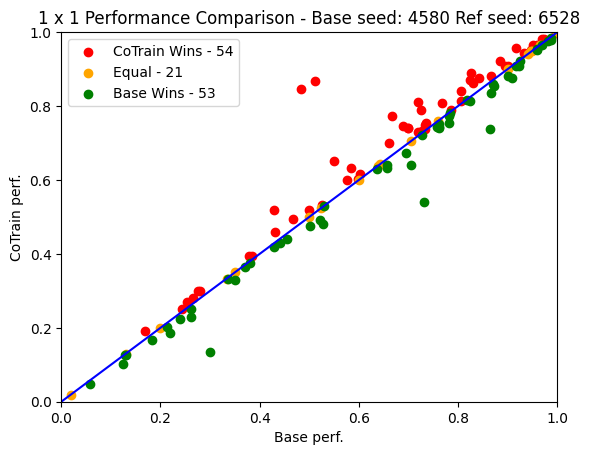

In [84]:
res_df['diff'] = res_df['ens_co'] - res_df['ens_base']
res_df.sort_values(by=['diff'], ascending=False)[:20]

,Dataset,ref_1,base_2,co_1,ens_base,ens_co,diff
56,HandOutlines,76.756757,36.486486,90.810811,0.483784,0.845946,0.362162
101,ShapeletSim,53.333333,51.666667,100.000000,0.511111,0.866667,0.355556
45,Fungi,66.666667,69.354839,87.096774,0.666667,0.774194,0.107527
7,BeetleFly,50.000000,55.000000,75.000000,0.550000,0.650000,0.100000
62,InsectEPGSmallTrain,68.674699,75.502008,88.353414,0.718876,0.811245,0.092369
35,EthanolLevel,25.600000,55.600000,55.000000,0.428000,0.520000,0.092000
79,NonInvasiveFetalECGThorax2,70.788804,84.478372,90.178117,0.826972,0.889567,0.062595
13,ChlorineConcentration,76.250000,68.333333,76.354167,0.726042,0.788281,0.062240
27,DodgerLoopWeekend,64.492754,71.014493,79.710145,0.688406,0.746377,0.057971
69,Meat,63.333333,38.333333,61.666667,0.583333,0.633333,0.050000


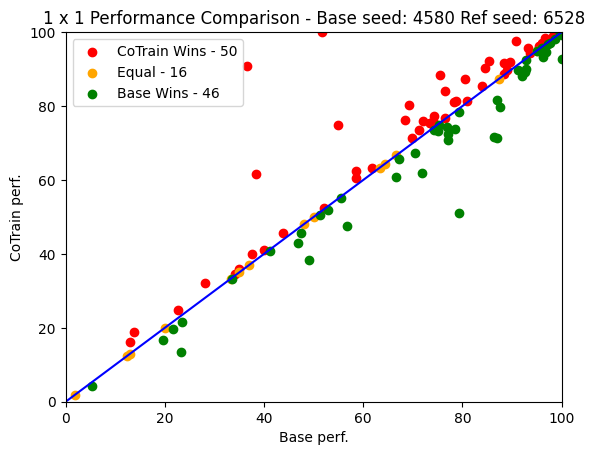

In [73]:
plot_1v1_perf(new_res_df, 100, base_seed=4580, ref_seed=6528)

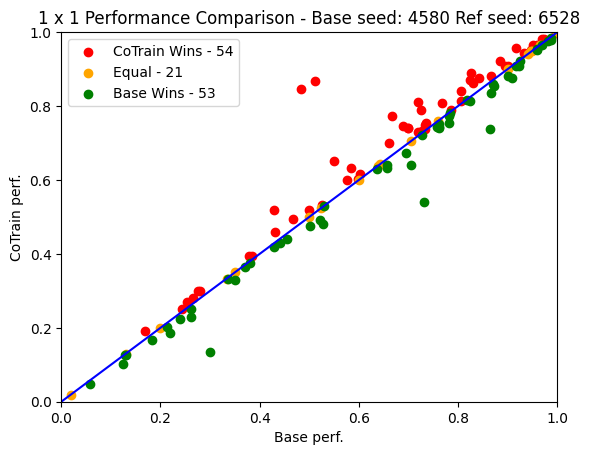

In [160]:
plot_1v1_perf(res_df, 1, base_seed=4580, ref_seed=6528)

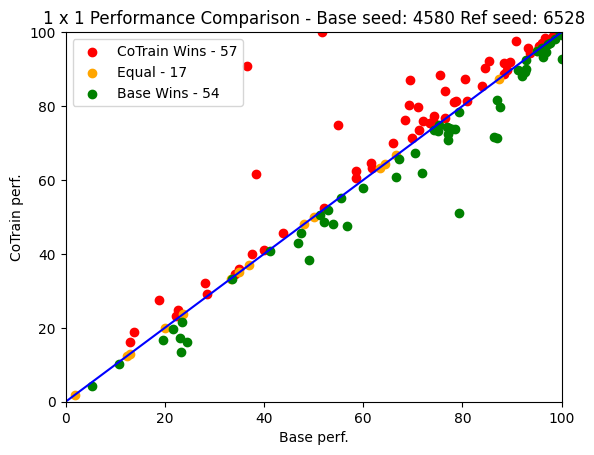

In [72]:
plot_1v1_perf(res_df, 100, base_seed=4580, ref_seed=6528)

In [94]:
res_df[(res_df['ens_base'] < res_df['ens_co']) & (res_df['base_2'] > res_df['co_1'])].sort_values(by=['diff'], ascending=False)


,Dataset,ref_1,base_2,co_1,ens_base,ens_co,diff
35,EthanolLevel,25.600000,55.600000,55.000000,0.428000,0.520000,0.092000
57,Haptics,37.987013,47.402597,45.779221,0.467532,0.493506,0.025974
47,GestureMidAirD2,56.153846,60.000000,57.692308,0.576923,0.600000,0.023077
84,PickupGestureWiimoteZ,48.000000,54.000000,48.000000,0.500000,0.520000,0.020000
112,ToeSegmentation1,92.982456,96.929825,94.736842,0.951754,0.964912,0.013158
105,SonyAIBORobotSurface1,94.342762,92.845258,92.512479,0.933444,0.943428,0.009983
102,ShapesAll,34.333333,41.166667,40.666667,0.385000,0.393333,0.008333
74,MiddlePhalanxTW,50.649351,51.298701,50.649351,0.525974,0.532468,0.006494
91,ProximalPhalanxOutlineAgeGroup,78.048780,77.073171,70.731707,0.785366,0.790244,0.004878
122,Wafer,99.691759,99.724205,99.707982,0.997242,0.997404,0.000162


In [161]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import random
import math

series = np.zeros(25)
centre = random.randint(7,17)
size = random.randrange(5,15,2)
height = random.randint(1,25)
if (size%2)==0:
    series[centre-math.floor(size/2):centre+math.floor(size/2)]=1
else:
    series[centre-math.floor(size/2):centre+math.floor(size/2)+1]=1
# return series*height, height


In [162]:
series

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [163]:
centre

12

In [164]:
size

5

In [165]:
height

6

In [166]:
centre-math.floor(size/2)

10

In [167]:
series = np.zeros(25)
series

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [168]:
centre = random.randint(7,17)
centre

7

In [169]:
size = random.randint(5,15)
size

13

In [170]:
height = random.randint(1,25)
height

4

In [171]:
series[centre-math.floor(size/2):centre+1]=np.linspace(0,1,math.floor(size/2)+1)
series

array([0.        , 0.        , 0.16666667, 0.33333333, 0.5       ,
       0.66666667, 0.83333333, 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [172]:
series[centre:centre+math.floor(size/2)+1]=np.linspace(1,0,math.floor(size/2)+1)
series
# return series*height, height


array([0.        , 0.        , 0.16666667, 0.33333333, 0.5       ,
       0.66666667, 0.83333333, 1.        , 0.83333333, 0.66666667,
       0.5       , 0.33333333, 0.16666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [187]:
import numpy as np

def generate_sample(dependency_strength=0.5):
  # Create base vector with correlated sub-vectors
  base_vector = np.random.rand(11) * 2 - 1
  base_vector[:5] += base_vector[:5].mean() * dependency_strength
  base_vector[5:] -= base_vector[5:].mean() * dependency_strength

  # Introduce long-range dependency from element 1 to element 10
  base_vector[10] = base_vector[1] * 2 + np.random.randn()

  return base_vector

# Generate dataset with different dependency strengths
dataset = [generate_sample(strength) for strength in range(5)]


In [195]:
range(15)

range(0, 15)

In [199]:
a = np.diag(dataset[0])


In [191]:
dataset[0]

array([ 0.47168666,  0.88762016, -0.07901991,  0.95784825, -0.74201513,
        0.60097471,  0.75851955, -0.65766209, -0.86319879, -0.6925519 ,
        2.72804143])

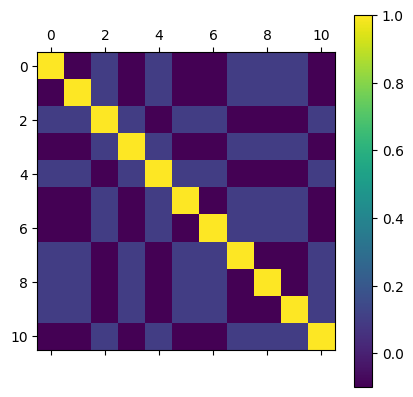

In [200]:
import matplotlib.pyplot as plt

def visualize_heatmap(data):
  data = np.diag(dataset[0])

  plt.matshow(np.corrcoef(data))
  plt.colorbar()
  plt.show()

visualize_heatmap(dataset[0])  # Visualize a sample


In [14]:
import random
import math

In [58]:
def create_random_triangle_class_1():
    type = random.randint(0, 1)
    series = np.zeros(25)
    centre = random.randint(7,17)
    size = random.randint(5,15)
    height = random.randint(1,25)
    
    if type == 0:
        type = -1 
    series[centre-math.floor(size/2):centre+1]=np.linspace(0,1,math.floor(size/2)+1) * type 
    series[centre:centre+math.floor(size/2)+1]=np.linspace(1,0,math.floor(size/2)+1) * type
    
    return series * height

def create_ds_with_class():
    subseries = []
    
    rand_square1 = create_random_triangle_class_1()
    subseries.append(rand_square1)
    rand_square2 = np.zeros(25)
    subseries.append(rand_square2)
    subseries.append(rand_square2)
    rand_square4 = create_random_triangle_class_1()
    subseries.append(rand_square4)

    order = np.arange(4)
    series = subseries[order[0]]

    for i in range(1,4):
        series = np.concatenate((series,subseries[order[i]]))

    return series.reshape(100, 1)

def create_toys_dataset_class_1(num_samples):
	dataset_input = np.empty((num_samples,100,1))
	# dataset_target = np.empty((num_samples,100,1))
	for i in range(num_samples):
		dataset_input[i] = create_ds_with_class()
		# dataset_target[i] = series_target
	# return dataset_input,dataset_target
	return dataset_input





def create_random_triangle_class_2():
    type = random.randint(0, 1)
    series = np.zeros(25)
    centre = random.randint(7,17)
    size = random.randint(5,15)
    height = random.randint(1,25)
    
    if type == 0:
        type = -1 
    series[centre-math.floor(size/2):centre+1]=np.linspace(0,1,math.floor(size/2)+1) * type 
    series[centre:centre+math.floor(size/2)+1]=np.linspace(1,0,math.floor(size/2)+1) * type
    
    return series * height

def create_ds_with_class_2():
    subseries = []
    
    rand_square1 = np.zeros(25)
    
    subseries.append(rand_square1)
    
    rand_square2 = create_random_triangle_class_2()
    subseries.append(rand_square2)

    rand_square4 = create_random_triangle_class_2()
    subseries.append(rand_square4)
    
    subseries.append(rand_square1)

    order = np.arange(4)
    series = subseries[order[0]]

    for i in range(1,4):
        series = np.concatenate((series,subseries[order[i]]))

    return series.reshape(100, 1)

def create_toys_dataset_class_2(num_samples):
	dataset_input = np.empty((num_samples,100,1))
	# dataset_target = np.empty((num_samples,100,1))
	for i in range(num_samples):
		dataset_input[i] = create_ds_with_class_2()
		# dataset_target[i] = series_target
	# return dataset_input,dataset_target
	return dataset_input

In [144]:
target_1 = np.zeros(100)
target_2 = np.ones(100)

In [145]:
input_class_1 = create_toys_dataset_class_1(100)
input_class_2 = create_toys_dataset_class_2(100)

In [146]:
X = np.concatenate((input_class_1, input_class_2))
y = np.concatenate((target_1, target_2))


In [147]:
y.shape

(200,)

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



In [150]:

from sklearn.preprocessing import LabelEncoder

def transform_labels(y_train, y_test):
    """
    Transform label to min equal zero and continuous
    For example if we have [1,3,4] --->  [0,1,2]
    """
    # no validation split
    # init the encoder
    encoder = LabelEncoder()
    # concat train and test to fit
    y_train_test = np.concatenate((y_train, y_test), axis=0)
    # fit the encoder
    encoder.fit(y_train_test)
    # transform to min zero and continuous labels
    new_y_train_test = encoder.transform(y_train_test)
    # resplit the train and test
    new_y_train = new_y_train_test[0:len(y_train)]
    new_y_test = new_y_train_test[len(y_train):]
    return new_y_train, new_y_test

y_train, y_test = transform_labels(y_train, y_test)

### Normalize the data

In [151]:
mu = X_train.mean()
std = X_train.std()
X_train = (X_train-mu)/std

mu_y = X_test.mean()
std_y = X_test.std()
X_test = (X_test-mu_y)/std_y

### Import pytorch's dataloader

In [152]:
import torch
from torch.utils.data import DataLoader, TensorDataset


X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)
X_train = X_train.permute(0, 2, 1)
X_test = X_test.permute(0, 2, 1)



trainlaoder = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
testloader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

### Classifier Model

In [182]:
class FCN_1_layer(nn.Module):

    def __init__(self, input_shape, nb_classes, filter_count):
        super(FCN_1_layer, self).__init__()
        self.nb_classes = nb_classes
        self.filter_count = filter_count

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.filter_count, kernel_size=10, stride=1, padding='same', bias=False)
        self.bn1 = nn.BatchNorm1d(self.filter_count,)
        self.relu = nn.ReLU()
    
        self.conv2 = nn.Conv1d(in_channels=self.filter_count, out_channels=self.filter_count, kernel_size=10, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm1d(self.filter_count,)

            
        self.conv3 = nn.Conv1d(in_channels=self.filter_count, out_channels=self.filter_count, kernel_size=10, stride=1, padding='same', bias=False)
        self.bn3 = nn.BatchNorm1d(self.filter_count,)


        self.avgpool1 = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(self.filter_count, self.nb_classes)

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.avgpool1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x

### Train the model

In [183]:
pred.shape

torch.Size([16, 2])

In [184]:
def test(model):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        for b_idx, (x, y) in enumerate(testloader):
            (x, y) = x.to(device), y.to(device)
            pred = model(x.float())

            loss = lossFn(pred, y)
            test_loss += loss.item()

            total += y.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)' % (test_loss / (b_idx + 1), 100. * correct / total, correct, total))
        return test_loss / (b_idx + 1), 100. * correct / total

In [ ]:
import torch.optim as optim

model = FCN_1_layer((100, 1), 2, 128)
lossFn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,)
EPOCHS = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for e in range(0, EPOCHS):
    model.train()

    # initlaize total training loss
    totalTainLoss = 0

    # initialize number of correct predictions in the training
    trainCorrect = 0

    for (x, y) in trainlaoder:
        # send the input to the device
        x, y = x.to(device), y.to(device)
        
        # perform a forward pass and calculate the training loss
        pred = model(x.float())
        loss = lossFn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
    

    print('Train loss: ', totalTainLoss.item())
    test(model)

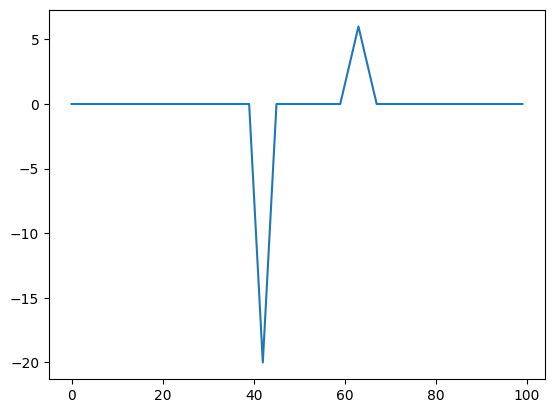

In [61]:
plt.plot(class_2_inputs[0])
# plt.plot(class_1_inputs[1])
# plt.plot(class_1_inputs[2])
# plt.plot(class_1_inputs[3])
# plt.plot(class_1_inputs[4])
# plt.plot(class_1_inputs[5])
# plt.plot(class_1_inputs[6])
# plt.plot(class_1_inputs[7])
# plt.plot(class_1_inputs[8])




In [2]:
def create_random_square():
	series = np.zeros(25)
	centre = random.randint(7,17)
	size = random.randrange(5,15,2)
	height = random.randint(1,25)
	if (size%2)==0:
		series[centre-math.floor(size/2):centre+math.floor(size/2)]=1
	else:
		series[centre-math.floor(size/2):centre+math.floor(size/2)+1]=1
	return series*height, height

def create_random_triangle():
	series = np.zeros(25)
	centre = random.randint(7,17)
	size = random.randint(5,15)
	height = random.randint(1,25)
	series[centre-math.floor(size/2):centre+1]=np.linspace(0,1,math.floor(size/2)+1)
	series[centre:centre+math.floor(size/2)+1]=np.linspace(1,0,math.floor(size/2)+1)
	return series*height


In [201]:
subseries = []
heights = []
rand_square1, height_square1 = create_random_square()
subseries.append(rand_square1)
heights.append(height_square1)
rand_square2, height_square2 = create_random_square()
subseries.append(rand_square2)
heights.append(height_square2)

rand_triangle1, height_triangle1 = create_random_triangle()
subseries.append(rand_triangle1)
heights.append(height_triangle1)
rand_triangle2, height_triangle2 = create_random_triangle()
subseries.append(rand_triangle2)
heights.append(height_triangle2)

order = np.arange(4)
np.random.shuffle(order)
mean_height_12 = (heights[order[0]]+heights[order[1]])/2
mean_height_34 = (heights[order[2]]+heights[order[3]])/2
subseries_target=[]

subseries_target.append(subseries[order[0]]/heights[order[0]]*mean_height_12)
subseries_target.append(subseries[order[1]]/heights[order[1]]*mean_height_12)
subseries_target.append(subseries[order[2]]/heights[order[2]]*mean_height_34)
subseries_target.append(subseries[order[3]]/heights[order[3]]*mean_height_34)

series = subseries[order[0]]
series_target = subseries_target[0]

for i in range(1,4):
    series = np.concatenate((series,subseries[order[i]]))
    series_target = np.concatenate((series_target,subseries_target[i]))

    
a = np.expand_dims(series,axis=1), 
b = np.expand_dims(series_target,axis=1)

In [202]:
series

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  2.5,  5. ,  2.5,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  3.6,  7.2, 10.8, 14.4, 18. , 14.4, 10.8,  7.2,
        3.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 12. , 12. ,
       12. , 12. , 12. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ])

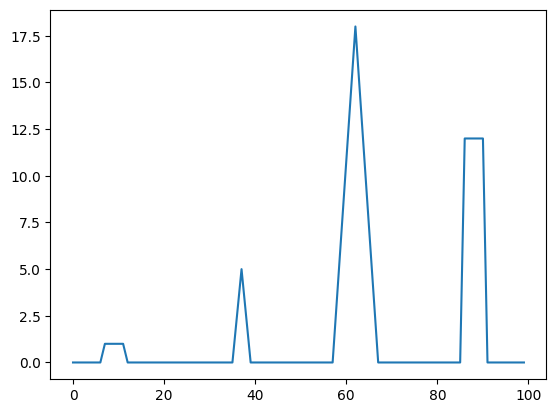

In [203]:
plt.plot(series)

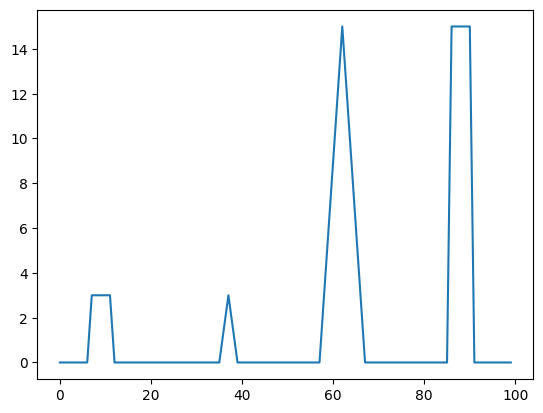

In [204]:
plt.plot(series_target)

In [ ]:
def create_random_series_target_mean_order():
	subseries=[]
	heights=[]
	rand_square1, height_square1 = create_random_square()
	subseries.append(rand_square1)
	heights.append(height_square1)
	rand_square2, height_square2 = create_random_square()
	subseries.append(rand_square2)
	heights.append(height_square2)
	rand_triangle1, height_triangle1 = create_random_triangle()
	subseries.append(rand_triangle1)
	heights.append(height_triangle1)
	rand_triangle2, height_triangle2 = create_random_triangle()
	subseries.append(rand_triangle2)
	heights.append(height_triangle2)

	order = np.arange(4)
	np.random.shuffle(order)

	mean_height_12 = (heights[order[0]]+heights[order[1]])/2
	mean_height_34 = (heights[order[2]]+heights[order[3]])/2
	subseries_target=[]
	subseries_target.append(subseries[order[0]]/heights[order[0]]*mean_height_12)
	subseries_target.append(subseries[order[1]]/heights[order[1]]*mean_height_12)
	subseries_target.append(subseries[order[2]]/heights[order[2]]*mean_height_34)
	subseries_target.append(subseries[order[3]]/heights[order[3]]*mean_height_34)

	series = subseries[order[0]]
	series_target = subseries_target[0]
	for i in range(1,4):
		series = np.concatenate((series,subseries[order[i]]))
		series_target = np.concatenate((series_target,subseries_target[i]))

	series = series + 0.01 * np.random.normal(loc=0.0, scale=1.0, size = series.shape)
	series_target = series_target + 0.01 * np.random.normal(loc=0.0, scale=1.0, size = series_target.shape)

	return np.expand_dims(series,axis=1), np.expand_dims(series_target,axis=1)

In [74]:
def plot_1v1_perf(res_df, acc_base, base_seed=4580, ref_seed=6528):
    # Define the points for the diagonal line
    x_line = [0, acc_base]
    y_line = [0, acc_base]

    # Define points for scatter plot
    x_scatter = res_df['ens_base'].tolist() 
    y_scatter = res_df['ens_co'].tolist() 

    x_above = np.array([x for x, y in zip(x_scatter, y_scatter) if y > x])
    y_above = np.array([y for x, y in zip(x_scatter, y_scatter) if y > x])

    x_same = np.array([x for x, y in zip(x_scatter, y_scatter) if y == x])
    y_same = np.array([y for x, y in zip(x_scatter, y_scatter) if y == x])

    x_below = np.array([x for x, y in zip(x_scatter, y_scatter) if y < x])
    y_below = np.array([y for x, y in zip(x_scatter, y_scatter) if y < x])

    # Plot the diagonal line
    plt.plot(x_line, y_line,  color='blue')
    num_wins = res_df[res_df['ens_co'] > res_df['ens_base']].shape[0]
    num_ties = res_df[res_df['ens_co'] == res_df['ens_base']].shape[0]
    num_losses = res_df[res_df['ens_co'] < res_df['ens_base']].shape[0]

    # Plot the scatter points
    plt.scatter(x_above, y_above, label='CoTrain Wins - ' + str(num_wins), color='red')
    plt.scatter(x_same, y_same, label='Equal - ' + str(num_ties), color='orange')
    plt.scatter(x_below, y_below, label='Base Wins - ' + str(num_losses), color='green')

    # # Set axis limits
    plt.xlim(0, acc_base)
    plt.ylim(0, acc_base)

    # Add labels and title
    plt.xlabel('Base perf.')
    plt.ylabel('CoTrain perf.')
    plt.title('1 x 1 Performance Comparison - Base seed: '+ str(base_seed) + ' Ref seed: '+ str(ref_seed))

    # Add a legend
    plt.legend()
    # plt.savefig('/home/javidan/Codes/Results/results/Diverse_Filters/FCN/fcn_kl_co' + str(base_seed) + '_ref_seed_' + str(ref_seed) + '_run_2.png')
    # Display the plot
    plt.show()

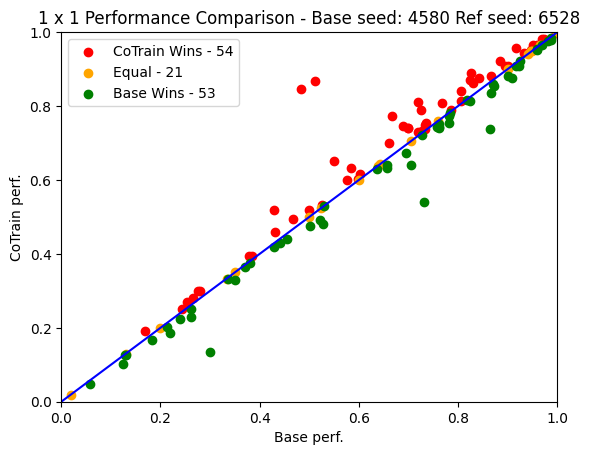

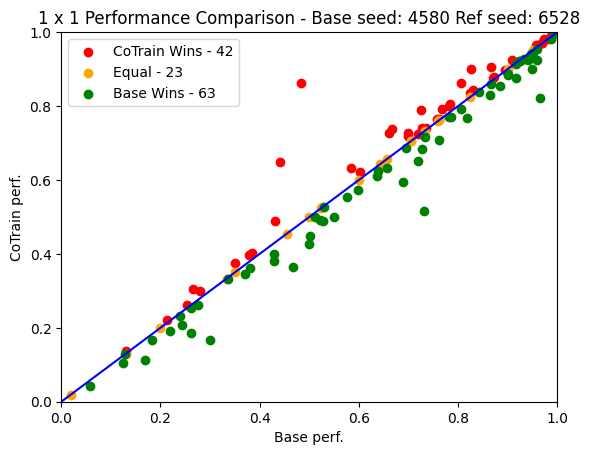

In [2]:
n_channels = 128
for c in (16,16,128):
    print('c = ', c)

c =  16
c =  16
c =  128


In [ ]:
import torch
import torch.nn as nn
import math

class Padding(nn.Module):

    def __init__(self, patch_size):
        super(Padding, self).__init__()
        self.patch_size = patch_size

    def forward(self, x):
        B, D, L = x.size()
        padd_size = self.patch_size - L % self.patch_size
        
        num_patches = math.ceil(L / self.patch_size)
        last_elements = x[:, :, -1:]
        num_missing_values = self.patch_size - (L % self.patch_size)
        if num_missing_values > 0:
            padding = last_elements.repeat(1, 1, num_missing_values)
            x = torch.cat([x, padding], dim=2)

        print('final shape: ', x.shape)

        x = x.view(B, D, -1, self.patch_size)

        return  x.permute(0, 2, 1, 3)


# Example usage:
patch_size = 10
num_heads = 2
sequence_length = 577
batch_size = 128

# Create sample input sequence data
input_data = torch.randn(batch_size, sequence_length, patch_size)

# Apply patching
patching_layer = Patching(patch_size)
patches = patching_layer(input_data)
print("Patched data shape:", patches.shape)

# Apply self-attention
attention_layer = SelfAttention(patch_size, num_heads)
output = attention_layer(patches)
print("Output shape after self-attention:", output.shape)

In [76]:
input_data = torch.randn(16, 128, 577)
patching_layer = Patching(10)
patches = patching_layer(input_data)

batch size:  16
Number of channels:  128
Sequence LengthL:  577
self patch size:  10
padd suze:  3
number of patches:  58
last_elements shape:  torch.Size([16, 128, 1])
padding shape:  torch.Size([16, 128, 3])
original shape:  torch.Size([16, 128, 580])
final shape:  torch.Size([16, 128, 58, 10])


In [43]:
last_elements = input_data[:, :, -1]
last_elements.shape

torch.Size([16, 128])

In [30]:
import tensorflow as tf

input = tf.random.normal((256, 237, 21))
conv_layer = tf.keras.layers.Conv1D(filters=1024, kernel_size=5, padding='same')
y = conv_layer(input)


In [31]:
y.shape

TensorShape([256, 237, 1024])

In [32]:
x = torch.randn(256, 237, 21)
conv_layer = nn.Conv1d(in_channels=21, out_channels=1024, kernel_size=5, padding=2)
y = conv_layer(x.permute(0, 2, 1))


In [33]:
y.shape

torch.Size([256, 1024, 237])

In [54]:
pip install einops

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [62]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    
    def __init__(self, transforms):
        self.transforms = transforms

    
    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
    
        
        return image, target


dataset = OxfordIIITPet(root='.', download=False, transforms=Compose(to_tensor))

In [103]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=8, emb_size=128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            # nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x:Tensor) -> Tensor:
        x = self.projection(x)
        return x

sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
sample_datapoint.shape

torch.Size([1, 3, 144, 144])

In [104]:
dataset[0][0].shape

torch.Size([3, 144, 144])

In [105]:
embedding = PatchEmbedding()(sample_datapoint)

In [106]:
embedding.shape

torch.Size([1, 324, 192])

# Attention

In [87]:
import aeon
from aeon.datasets import load_arrow_head

x_train, y_train = load_arrow_head(split='TRAIN')
x_test, y_test = load_arrow_head(split='TEST')

std_ = x_train.std(axis=1, keepdims=True)
std_[std_ == 0] = 1.0
x_train = (x_train - x_train.mean(axis=1, keepdims=True)) / std_

std_ = x_test.std(axis=1, keepdims=True)
std_[std_ == 0] = 1.0
x_test = (x_test - x_test.mean(axis=1, keepdims=True)) / std_


In [88]:
inputs = torch.randn(16, 128, 251)

In [101]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=128, patch_size=10, emb_size=32):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h p) -> b h (p c)', p=patch_size,),
            nn.Linear(patch_size * in_channels, emb_size)
        )

    def forward(self, x:Tensor) -> Tensor:
        x = self.projection(x)
        return x

patched_input = PatchEmbedding()(padded_input)
patched_input.shape

torch.Size([16, 58, 32])

In [102]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        
        # Compute the positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # Register the positional encodings as buffer (not trainable)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # Add the positional encodings to the input embeddings
        batch_size, num_patches, patch_length = x.size()
        positional_encodings = self.pe[:, :num_patches, :]
        return x + positional_encodings


d_model = 32  # Embedding dimension (same as patch length)
max_len = 832  # Maximum sequence length
pos_encoder = PositionalEncoding(d_model, max_len)
output_data = pos_encoder(patched_input)
output_data.shape

torch.Size([16, 58, 32])